In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

# Demographics Functions Import
from Python_Functions.demographics_functions import get_gene_data_RNAP

# EHR Functions Import
from Python_Functions.EHR_functions import extract_filetype_csvs, concat_single_csv_diagnoses, concat_single_csv_any

### Get Rid of Warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Notebook Description

This notebook includes the code utilized to generate the figures/tables for the _______ analysis. View the README for information on the components of this repo. 

The data generated by this code can not be replicated without [CIELO](https://cielo.wustl.edu/#) and [REDCap](https://redcap.wustl.edu/redcap/) access to the BGR data.

# Data Initializations

The relative locations of relevant data for this analysis are provided below. The actual data that these files reference was downloaded from CIELO and REDCap.

In [3]:
selected_gene = "MYT1L"
# For all genes put 'All'

# Data from CIELO and REDCap
deidentified_cielo_folder = "Current_Data/CIELO_data_4_29"
redcap_alldata_file = "Current_Data/AllData_DATA_LABELS_2024-04-29.csv"
redcap_feedback_report = "Current_Data/RNAPFeedbackReportFo_DATA_LABELS_2024-05-21.csv"
GC_seizure_survey = "Current_Data/GC_Seizure_April_2024.csv"
RNAP_seizure_survey = "Current_Data/SeizureQuestionnaire_DATA_LABELS_2024-05-27.csv"
myt1l_table_loc = "Current_Data/MYT1L_Table.csv" # Table 1 of paper with non-hidden IDs

# Available Mapping Data
phecode_map_file = "Current_Data/miscellaneous/Phecode_map_v1_2_icd10cm_beta.csv"
med_names_mapped_loc = 'Current_Data/miscellaneous/med_names_MYT1L_mapped.csv'

# **Paper Figure 1**: DP-4 and Shipley Scores

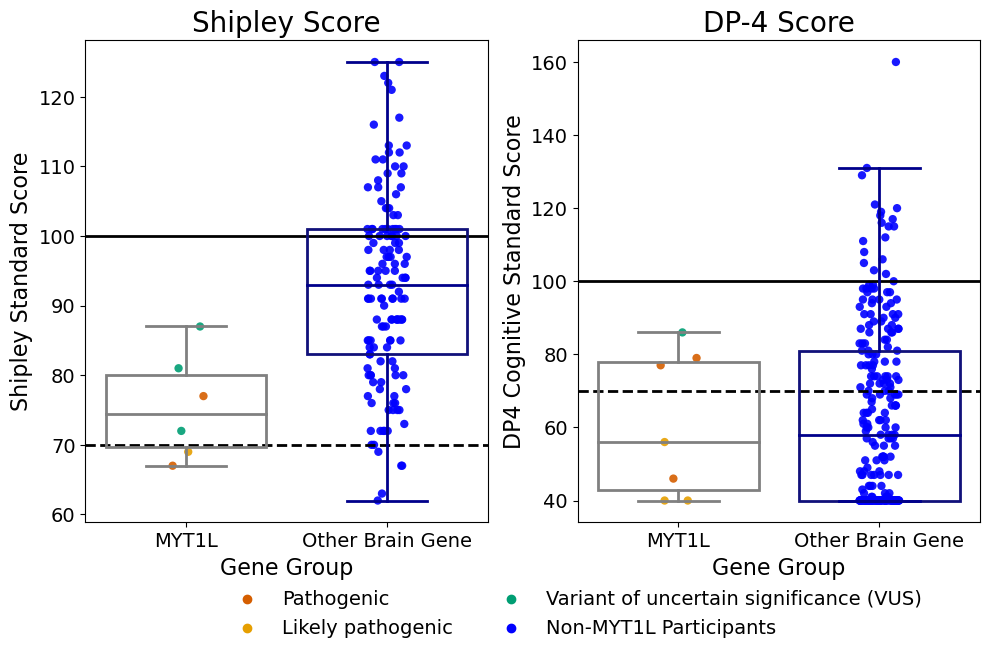

In [ ]:
# Create combined figure with 2 subplots (side by side)
colors = ['gray', 'darkblue']
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

# load essential data
gene_df = get_gene_data_RNAP(redcap_alldata_file)
# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

# Remove data from patients who do not have MYT1L from the data
patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report)

# Remove from data if individuals took a valid shipley 
shipley_invalid = np.unique(all_scores.loc[all_scores["Please indicate here if the Shipley assessment is considered invalid"].notnull(),'Study ID'])
all_scores_ship = all_scores[[True if x not in shipley_invalid else False for x in all_scores['Study ID']]]
also_took_shipley = np.unique(all_scores_ship.loc[all_scores['Shipley Standard Score'].notnull(),'Study ID'])
all_scores = all_scores[[True if x not in also_took_shipley else False for x in all_scores['Study ID']]].rename(columns = {"Study ID":"EntityID"})

# Merge on Gene and other things
# Condense to Correct Gene 
gene_df['EntityID'] = gene_df['EntityID'].astype(int)
all_scores = all_scores.merge(gene_df, on = "EntityID")
for i in range(len(all_scores)):
    if all_scores.loc[i,"Brain Gene"] != selected_gene:
        all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
gene_scores = all_scores[all_scores['Brain Gene'] == selected_gene]
gene_scores = gene_scores[gene_scores['DP4 Cognitive Standard Score'].notnull()]
non_gene_scores = all_scores[all_scores['Brain Gene'] == "Other Brain Gene"]
non_gene_scores = non_gene_scores[non_gene_scores['DP4 Cognitive Standard Score'].notnull()]

# Get Data In the Format Needed to Compare Boxplots 
plotting_df = pd.concat([gene_scores[['ACMG Classification', 'Brain Gene', 'DP4 Cognitive Standard Score']], non_gene_scores[['ACMG Classification', 'Brain Gene', 'DP4 Cognitive Standard Score']]])
plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].fillna("Variant of Uncertain Significance (VUS)")
plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].replace("Variant of Uncertain Significance (VUS)","Variant of uncertain significance (VUS)")
plotting_df.loc[plotting_df['Brain Gene'] == "Other Brain Gene", "ACMG Classification"] = "Non-MYT1L Participants"

# Solid black line at 100
ax = axes[1]
np.random.seed(42)
sns.stripplot(x='Brain Gene',y='DP4 Cognitive Standard Score',data=plotting_df,jitter=True,color='0.3',alpha=.9,size=6,ax=ax, hue = "ACMG Classification",
             palette={'Likely pathogenic': "#E69F00", 
                      'Non-MYT1L Participants': "Blue", 
                      'Pathogenic': "#D55E00",
                       'Variant of uncertain significance (VUS)': "#009E73"}, zorder = 0)
sns.boxplot(x='Brain Gene',y='DP4 Cognitive Standard Score',data=plotting_df,showmeans=False,palette=['gray', 'darkblue'], ax=ax, showfliers = False)

# grab legend handles/labels from first subplot
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

# Now remove fill but keep colored edges
for patch in ax.patches:
    fc = patch.get_facecolor()   # grab palette color
    patch.set_facecolor('none')  # transparent fill
    patch.set_edgecolor(fc)      # outline = palette color
    patch.set_linewidth(2)       # make outline a bit thicker

# Fix lines (whiskers, caps, medians)
lines_per_box = 5
for i, color in enumerate(colors):
    # Get the 6 lines for this box
    for line in ax.lines[i*lines_per_box:(i+1)*lines_per_box]:
        line.set_color(color)
        line.set_mfc(color)  # for fliers (if enabled)
        line.set_mec(color)
        line.set_linewidth(2)
        
# Customizing the plot
ax.axhline(y=100, color='black', linestyle='-', linewidth=2, zorder = 0)
ax.axhline(y=70, color='black', linestyle='--', linewidth=2, zorder = 0)
ax.set_xlabel('Gene Group', fontsize=16)
ax.set_ylabel('DP4 Cognitive Standard Score', fontsize=16)
ax.set_title(f'DP-4 Score', fontsize=20)
ax.tick_params(axis='x', labelsize=14)  # x-axis tick labels size
ax.tick_params(axis='y', labelsize=14)



###################### SHIPLAY

# load essential data
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report).rename(columns = {"Study ID":"EntityID"})

# # Merge on Gene and other things
gene_df['EntityID'] = gene_df['EntityID'].astype(int)
all_scores = all_scores.merge(gene_df, on = "EntityID")
for i in range(len(all_scores)):
    if all_scores.loc[i,"Brain Gene"] != selected_gene:
        all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
gene_scores = all_scores[all_scores['Brain Gene'] == selected_gene]
gene_scores = gene_scores[gene_scores['Shipley Standard Score'].notnull()]
non_gene_scores = all_scores[all_scores['Brain Gene'] == "Other Brain Gene"]
non_gene_scores = non_gene_scores[non_gene_scores['Shipley Standard Score'].notnull()]

# # Get Data In the Format Needed to Compare Boxplots 
plotting_df = pd.concat([gene_scores[['ACMG Classification', 'Brain Gene', 'Shipley Standard Score']], non_gene_scores[['ACMG Classification', 'Brain Gene', 'Shipley Standard Score']]])
plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].fillna("Variant of Uncertain Significance (VUS)")
plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].replace("Variant of Uncertain Significance (VUS)","Variant of uncertain significance (VUS)")
plotting_df.loc[plotting_df['Brain Gene'] == "Other Brain Gene", "ACMG Classification"] = "Non-MYT1L Participants"

######################################### BELOW IS WHAT WORKING ON

# Solid black line at 100
ax = axes[0]
sns.stripplot(x='Brain Gene',y='Shipley Standard Score',data=plotting_df,jitter=True,color='0.3',alpha=.9,size=6,ax=ax, hue = "ACMG Classification",
             palette={'Likely pathogenic': "#E69F00", 
                      'Non-MYT1L Participants': "blue", 
                      'Pathogenic': "#D55E00",
                       'Variant of uncertain significance (VUS)': "#009E73"}, legend = False, zorder = 0)
sns.boxplot(x='Brain Gene',y='Shipley Standard Score',data=plotting_df,showmeans=False,palette=['gray', 'darkblue'], ax=ax, showfliers = False)

# Now remove fill but keep colored edges
for patch in ax.patches:
    fc = patch.get_facecolor()   # grab palette color
    patch.set_facecolor('none')  # transparent fill
    patch.set_edgecolor(fc)      # outline = palette color
    patch.set_linewidth(2)       # make outline a bit thicker

# Fix lines (whiskers, caps, medians)
colors_shipley = ['gray', 'darkblue']
lines_per_box = 5
for i, color in enumerate(colors):
    # Get the 6 lines for this box
    for line in ax.lines[i*lines_per_box:(i+1)*lines_per_box]:
        line.set_color(color)
        line.set_mfc(color)  # for fliers (if enabled)
        line.set_mec(color)
        line.set_linewidth(2)
        
# Customizing the plot
ax.axhline(y=100, color='black', linestyle='-', linewidth=2, zorder = 0)
ax.axhline(y=70, color='black', linestyle='--', linewidth=2, zorder = 0)
ax.set_xlabel('Gene Group', fontsize=16)
ax.set_ylabel('Shipley Standard Score', fontsize=16)
ax.set_title(f'Shipley Score', fontsize=20)
ax.tick_params(axis='x', labelsize=14)  # x-axis tick labels size
ax.tick_params(axis='y', labelsize=14)

# Place the legend from the first subplot under everything
legend = fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.58, -0.10))

plt.tight_layout()
fig.savefig("MYT1L_paper_figures/DP4_Shipley.svg", bbox_inches="tight", bbox_extra_artists=(legend,), format="svg")
plt.show()
plt.close()

# **Paper Figure 2**: - Vineland Scores

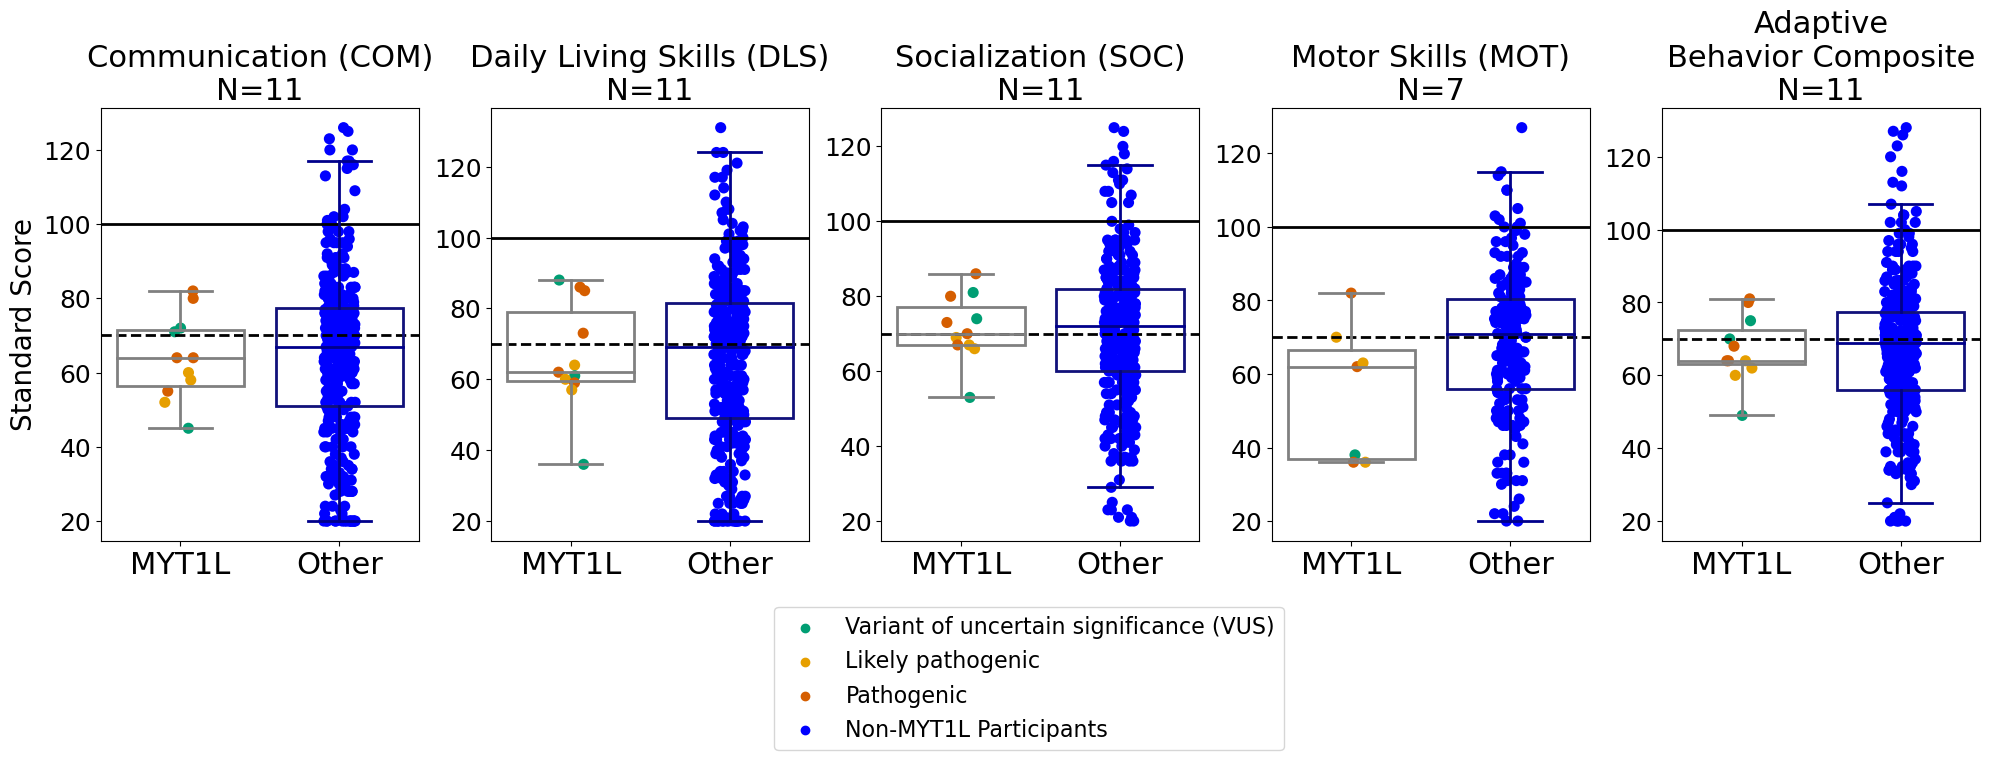

In [ ]:
# Load in the essential data
colors = ['gray', 'darkblue']
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report)

# Data Formatting and Creation!
all_scores = all_scores.rename(columns = {"Study ID": "EntityID"})
columns_to_investigate = ["Vineland Standard Score - Communication (COM)", 
                         "Vineland Standard Score - Daily Living Skills (DLS)",
                         "Vineland Standard Score - Socialization (SOC)",
                         "Vineland Standard Score - Motor Skills (MOT)",
                         "Vineland Standard Score - Adaptive Behavior Composite (ABC)"]

# Further Data Manipulation
gene_df['EntityID'] = gene_df['EntityID'].astype(int)
all_scores = all_scores.merge(gene_df, on = "EntityID")
for i in range(len(all_scores)):
    if all_scores.loc[i,"Brain Gene"] != selected_gene:
        all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
gene_scores = all_scores[all_scores['Brain Gene'] == selected_gene]
non_gene_scores = all_scores[all_scores['Brain Gene'] == "Other Brain Gene"]

# Initialize Some Information for Our Figures 
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
x_ticks = list(range(20,200,20))
i = 0

# Iterate Thouh Each of the columns we want to get our info for!!!
for column in columns_to_investigate:
    # Get Temporary Gene and Non-Gene Scores
    gene_scores_tmp = copy.deepcopy(gene_scores[gene_scores[column].notnull()])
    non_gene_scores_tmp = copy.deepcopy(non_gene_scores[non_gene_scores[column].notnull()])
    
    # Get Temporary DataFrames that we will use to plot our information
    plotting_df = pd.concat([gene_scores_tmp[['ACMG Classification', 'Brain Gene', column]], non_gene_scores_tmp[['ACMG Classification', 'Brain Gene', column]]])
    plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].fillna("Variant of Uncertain Significance (VUS)")
    plotting_df['ACMG Classification'] = plotting_df['ACMG Classification'].replace("Variant of Uncertain Significance (VUS)","Variant of uncertain significance (VUS)")
    plotting_df.loc[plotting_df['Brain Gene'] == "Other Brain Gene", "ACMG Classification"] = "Non-MYT1L Participants"
    plotting_df['Brain Gene'] = plotting_df['Brain Gene'].replace("Other Brain Gene", 'Other')
    
    # Plot our data
    ax = axes[i]
    #x='Brain Gene',y=column
    sns.stripplot(x='Brain Gene',y=column, data=plotting_df, jitter=True, color='0.3', alpha=1, size=8, ax=ax, hue="ACMG Classification",
                  palette={'Likely pathogenic': "#E69F00", 
                           'Non-MYT1L Participants': "Blue", 
                           'Pathogenic': "#D55E00",
                           'Variant of uncertain significance (VUS)': "#009E73",
                           'Other': "Red"}, legend=True, zorder=0)
    sns.boxplot(x='Brain Gene',y=column, data=plotting_df, showmeans=False, palette=['gray', 'darkblue'], ax=ax, showfliers=False)
    
    # Now remove fill but keep colored edges
    for patch in ax.patches:
        fc = patch.get_facecolor()   # grab palette color
        patch.set_facecolor('none')  # transparent fill
        patch.set_edgecolor(fc)      # outline = palette color
        patch.set_linewidth(2)       # make outline a bit thicker
    
    # Fix lines (whiskers, caps, medians)
    num_groups = len(colors)
    lines_per_box = 5
    for j, color in enumerate(colors):
        # Get the 6 lines for this box
        for line in ax.lines[j*lines_per_box:(j+1)*lines_per_box]:
            line.set_color(color)
            line.set_mfc(color)  # for fliers (if enabled)
            line.set_mec(color)
            line.set_linewidth(2)
            
    # Customizing the plot
    ax.axhline(y=100, color='black', linestyle='-', linewidth=2, zorder=0)
    ax.axhline(y=70, color='black', linestyle='--', linewidth=2, zorder=0)
    if i == 0:  
        ax.set_ylabel('Standard Score', fontsize=20)
    else:
        ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=16)
    if i == 4:
        ax.set_title('Adaptive\n' + 'Behavior Composite' + '\nN=' + str(sum(gene_scores[column].notnull())), fontsize=22)
    else:
        ax.set_title(column.split('- ')[1] + '\nN=' + str(sum(gene_scores[column].notnull())), fontsize=22)
    ax.tick_params(axis='y', labelsize=18) 
    ax.tick_params(axis='x', labelsize=22)

    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    if i == 5:
        ax.remove()
    i = i + 1

plt.subplots_adjust(hspace=0.62, wspace=0.25, top=0.88)
plt.tight_layout()
fig.legend(handles, labels, loc='center right', fontsize=16, bbox_to_anchor=(.65, -0.14))
fig.savefig("MYT1L_paper_figures/Vineland_scores.svg", bbox_inches="tight", format="svg")
plt.show()
plt.close()

# **Figure 3**: ASEBA Scores

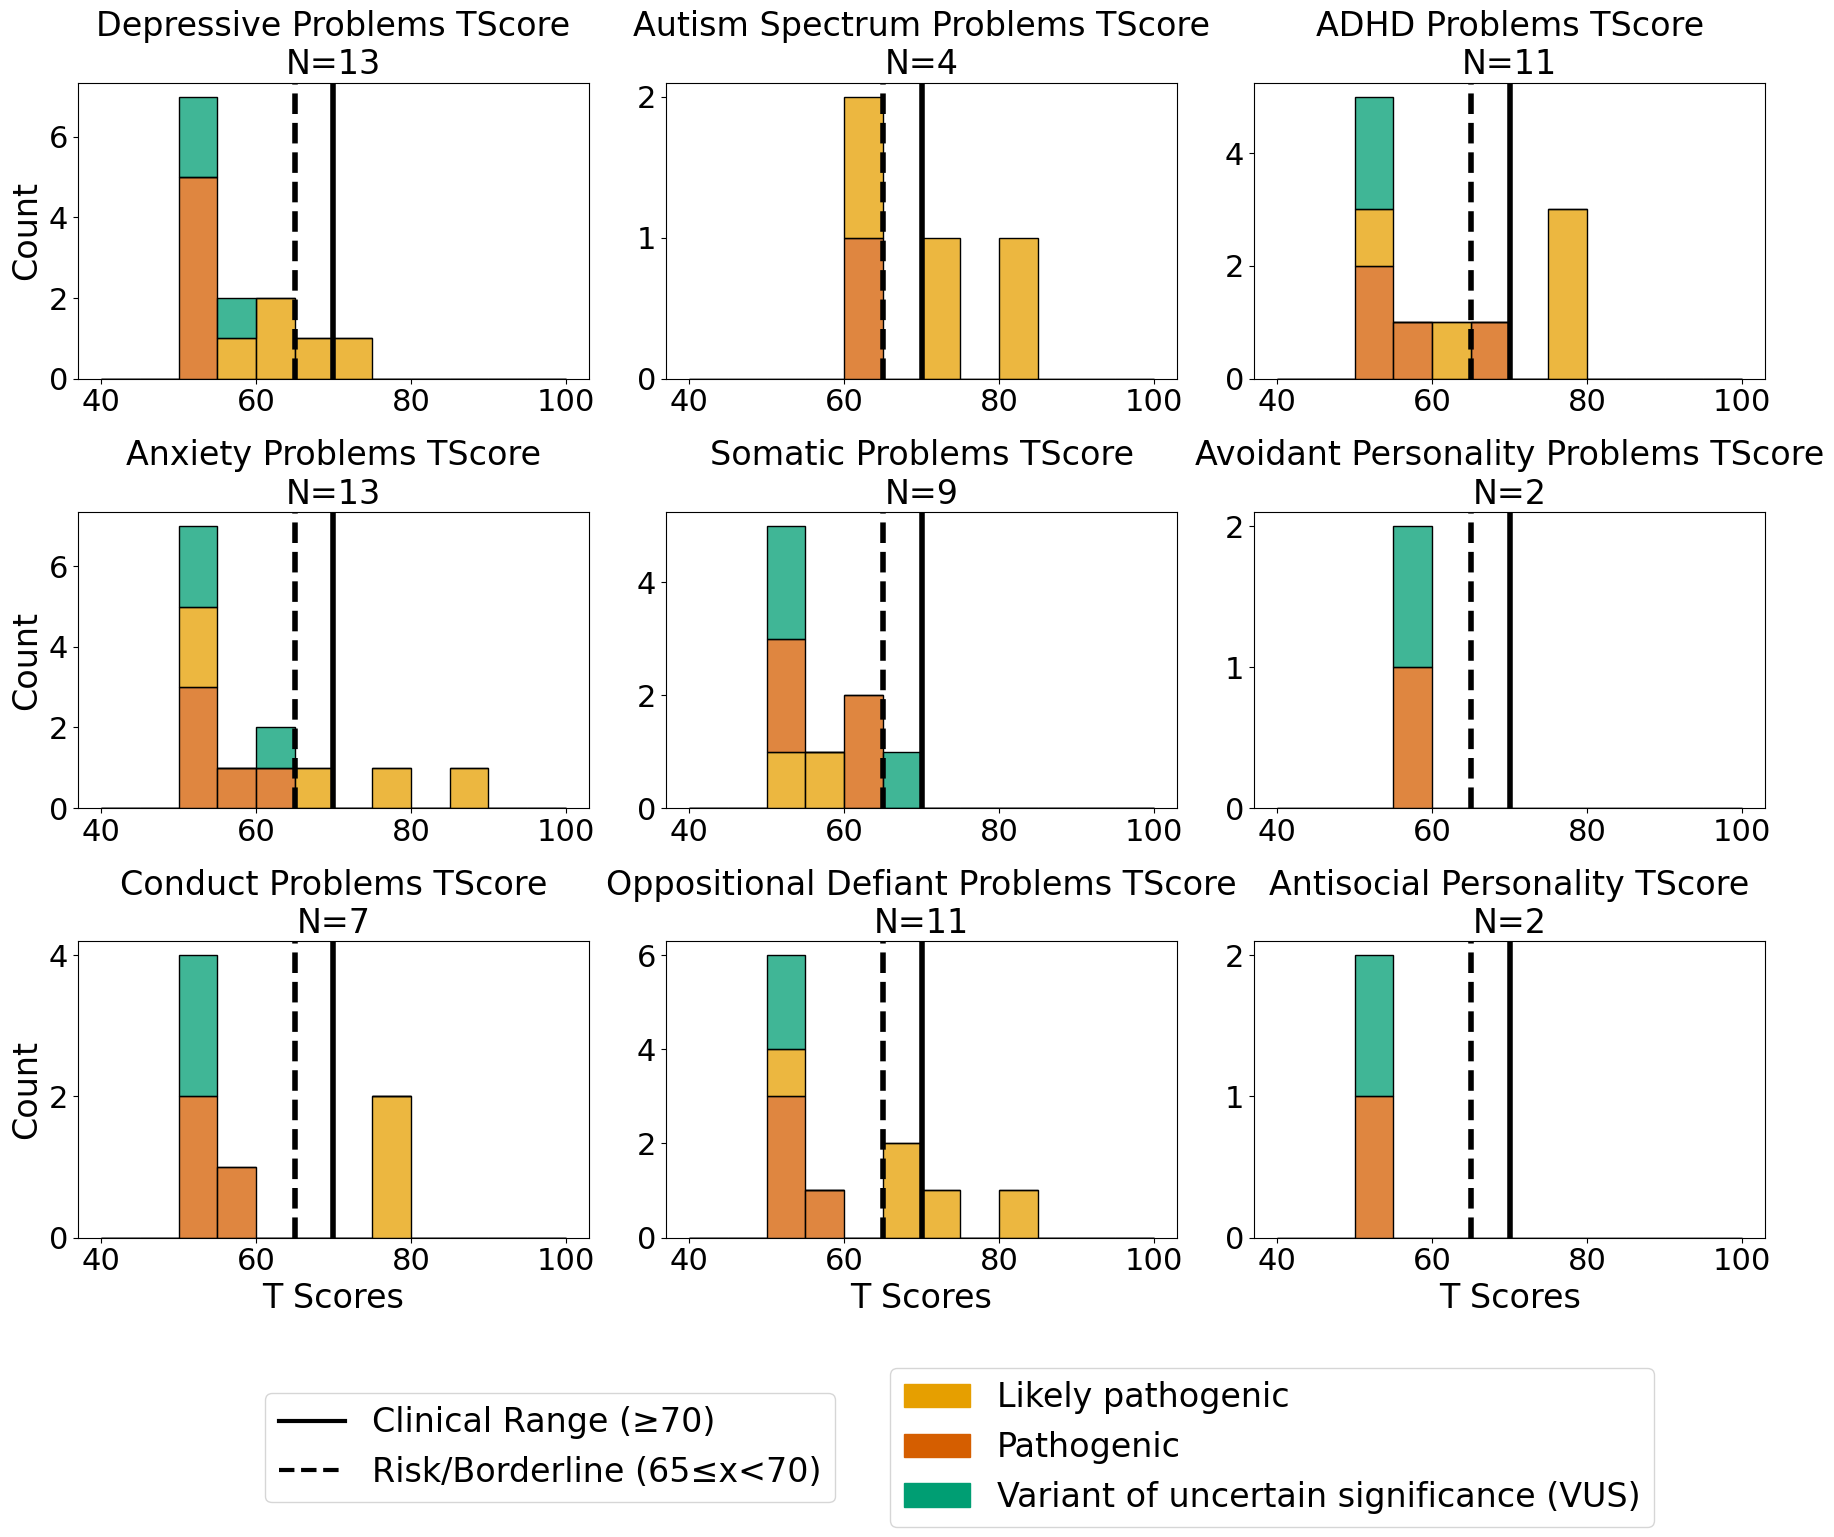

In [ ]:
# Load in Important Information
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###


patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report)

all_scores = all_scores.rename(columns = {'ASEBA Attention_Deficit__Hyperactivity_Problems_TScore':"ASEBA ADHD_Problems_TScore", "Study ID":"EntityID"})
ASEBA_column_list = ['ASEBA Depressive_Problems_TScore',
                    'ASEBA Anxiety_Problems_TScore',
                    'ASEBA Autism_Spectrum_Problems_TScore',
                    'ASEBA Somatic_Problems_TScore',
                    "ASEBA ADHD_Problems_TScore", 
                    'ASEBA Oppositional_Defiant_Problems_TScore',
                    'ASEBA Conduct_Problems_TScore',
                    'ASEBA Avoidant_Personality_Problems_TScore',
                    'ASEBA Antisocial_Personality_TScore',
                    ]


if selected_gene != "All":
    gene_df['EntityID'] = gene_df['EntityID'].astype(int)
    all_scores = all_scores.merge(gene_df, on = "EntityID")
    for i in range(len(all_scores)):
        if all_scores.loc[i,"Brain Gene"] != selected_gene:
            all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
    all_scores = all_scores[all_scores['Brain Gene'] == selected_gene]

fig, axes = plt.subplots(3, 3, figsize=(25, 15))
#fig, axes = plt.subplots(1, 5, figsize=(30, 7))
axes_list = [(0,0),(1,0),(0,1),(1,1),(0,2),(2,1),(2,0),(1,2),(2,2)]
handles, labels = None, None
i = 0
##### NOTE MIGHT NEED TO ADD MORE WITH NEW DATA
palette = {'Likely pathogenic': "#E69F00", 'Pathogenic': "#D55E00",'Variant of uncertain significance (VUS)': "#009E73"}
for column in ASEBA_column_list:
    
    # Create Custom Df for Plotting
    plotting_df = copy.deepcopy(all_scores.loc[all_scores[column].notnull(), ['Brain Gene', 'ACMG Classification',column]])
    
    # Create Plots
    ax = axes[int(axes_list[i][0]), int(axes_list[i][1])]
    sns.histplot(x=column, data = plotting_df, binwidth=5, binrange = (40,100), color = 'maroon', ax=ax, hue='ACMG Classification', multiple = 'stack', palette=palette, legend = False)
    ax.set_title(column.split(" ")[1].replace("_"," ") + '\nN=' + str(sum(plotting_df[column].notnull())), fontsize = 24)
    ax.axvline(x=70, color='black', linestyle='-', linewidth=4)
    ax.axvline(x=65, color='black', linestyle='--', linewidth=4)
    ax.set_xlabel('T Scores', fontsize=18)
    if i in [0,1,6]:
        ax.set_ylabel('Count', fontsize=24)
    else:
        ax.set_ylabel('', fontsize=24)
    if i in [6,5,8]:
        ax.set_xlabel('T Scores', fontsize=24)
    else:
        ax.set_xlabel('', fontsize=18)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    i = i + 1

plt.subplots_adjust(hspace=0.45, wspace=0.15, right=0.80)

# Manually Construct Legends
### Legend 1
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in palette.items()
]
legend = fig.legend(handles=legend_handles,loc='center left',fontsize=24,bbox_to_anchor=(.45, -0.03),borderaxespad=0.)
### Legend 2
solid_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=3,
                           label='Clinical Range (≥70)')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=3,
                            label='Risk/Borderline (65≤x<70)')

legend2 = fig.legend(
    handles=[solid_line, dashed_line],
    loc='center left',
    fontsize=24,
    bbox_to_anchor=(.2, -0.03),   # shift below the first legend
    borderaxespad=0.
)

# Save and Show Data
plt.subplots_adjust(right=0.80)  # leave margin for legends
fig.savefig("MYT1L_paper_figures/ASEBA_comparison.svg", bbox_inches="tight", bbox_extra_artists=(legend,legend2), format="svg")
plt.show()
plt.close()

# **Figure 4**: Phecode Comparison

### Data Initializations / Loading

In [ ]:
# Load in Data
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
Phe_map = pd.read_csv(phecode_map_file, encoding = "latin-1").rename(columns = {'icd10cm':'icd10_code'})

# Load EHR encounters into single dataframe
encounter_dict = extract_filetype_csvs(deidentified_cielo_folder, "Encounters")
encounter_df = concat_single_csv_any(encounter_dict)
# Load EHR diagnoses into single dataframe
diagnoses_dict = extract_filetype_csvs(deidentified_cielo_folder, "Diagnoses")
diagnosis_df = concat_single_csv_diagnoses(diagnoses_dict)

# Remove VUS
gene_df = gene_df[gene_df['ACMG Classification'] != 'Variant of uncertain significance (VUS)'] 

### Generate Our Figure

Number of Individuals with Gene and Diagnoses: 6
Number of Individuals with Gene and Diagnoses: 168


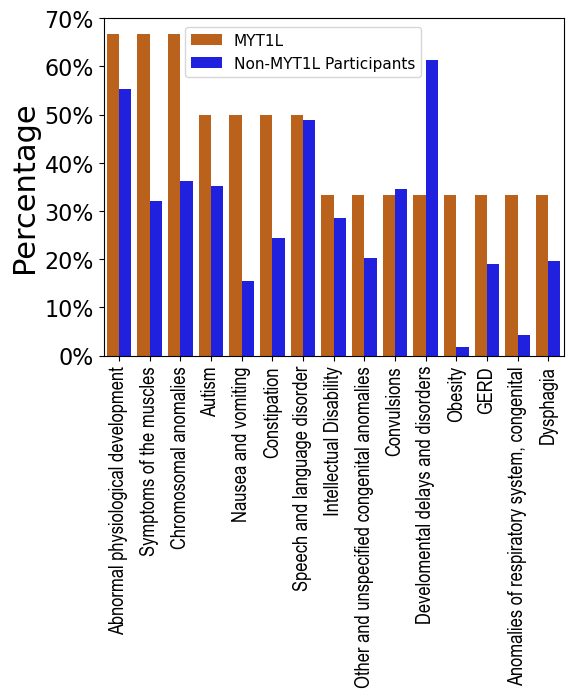

,phecode_str,count,Percentage,Gene
0,Abnormal physiological development,4,0.666667,MYT1L
1,Symptoms of the muscles,4,0.666667,MYT1L
2,Chromosomal anomalies,4,0.666667,MYT1L
3,Autism,3,0.500000,MYT1L
4,Nausea and vomiting,3,0.500000,MYT1L
5,Constipation,3,0.500000,MYT1L
6,Speech and language disorder,3,0.500000,MYT1L
7,Intellectual Disability,2,0.333333,MYT1L
8,Other and unspecified congenital anomalies,2,0.333333,MYT1L
9,Convulsions,2,0.333333,MYT1L


In [8]:
from matplotlib.ticker import PercentFormatter
number_diagnoses_required_gene = 2
diagnosis_data = diagnosis_df.rename(columns = {"ICD10_CODE":"icd10_code", "PARTICIPANTID":"participantid"})

# Reduced to only note set 
if selected_gene != "All":
    gene_df['participantid'] = gene_df['EntityID']
    diagnosis_data = diagnosis_data.merge(gene_df, on = "participantid")
    gene_diagnoses = copy.deepcopy(diagnosis_data[diagnosis_data['Brain Gene'] == selected_gene])
    other_diagnoses = copy.deepcopy(diagnosis_data[diagnosis_data['Brain Gene'] != selected_gene])

# Calculate the number of phecodes for our brain gene
number_gene_individuals  = len(np.unique(gene_diagnoses['participantid']))
print(f"Number of Individuals with Gene and Diagnoses: {str(number_gene_individuals)}")
gene_phecodes = gene_diagnoses.merge(Phe_map, on='icd10_code', how='left')
gene_phecodes = gene_phecodes.drop_duplicates(subset = ['participantid', "phecode_str"]).reset_index(drop=True)
gene_phecodes = gene_phecodes.groupby("phecode_str").agg('count')['participantid'].reset_index().rename(columns = {'participantid': 'count'})
gene_phecodes['Percentage'] = gene_phecodes['count']/number_gene_individuals
gene_phecodes = gene_phecodes.sort_values(by = "count", ascending = False).reset_index(drop=True)
gene_phecodes = gene_phecodes[gene_phecodes['count'] >= number_diagnoses_required_gene]
gene_phecodes = gene_phecodes[~gene_phecodes['phecode_str'].str.contains('health hazards')]
gene_phecodes = gene_phecodes[gene_phecodes['phecode_str'] != 'Other tests']
gene_phecodes = gene_phecodes[gene_phecodes['phecode_str'] != 'Genetic Test']
gene_phecodes = gene_phecodes[gene_phecodes['phecode_str'] != 'Family history'].reset_index(drop=True)

# Caclulate the number of phecodes for our non-brain gene 
number_other_individuals  = len(np.unique(other_diagnoses['participantid']))
print(f"Number of Individuals with Gene and Diagnoses: {str(number_other_individuals)}")
other_phecodes = other_diagnoses.merge(Phe_map, on='icd10_code', how='left')
other_phecodes = other_phecodes.drop_duplicates(subset = ['participantid', "phecode_str"]).reset_index(drop=True)
other_phecodes = other_phecodes.groupby("phecode_str").agg('count')['participantid'].reset_index().rename(columns = {'participantid': 'count'})
other_phecodes['Percentage'] = other_phecodes['count']/number_other_individuals
other_phecodes = other_phecodes[other_phecodes['phecode_str'].isin(gene_phecodes['phecode_str'])]

# Shorten Long Phecode Names
gene_phecodes['phecode_str'] = gene_phecodes['phecode_str'].replace("Persons with potential health hazards related to socioeconomic, psychosocial, and other circumstances", "Health hazards")
gene_phecodes['phecode_str'] = gene_phecodes['phecode_str'].replace("Lack of normal physiological development, unspecified", "Abnormal physiological development")
other_phecodes['phecode_str'] = other_phecodes['phecode_str'].replace("Persons with potential health hazards related to socioeconomic, psychosocial, and other circumstances", "Health hazards")
other_phecodes['phecode_str'] = other_phecodes['phecode_str'].replace("Lack of normal physiological development, unspecified", "Abnormal physiological development")
gene_phecodes['Gene'] = 'MYT1L'
other_phecodes['Gene'] = 'Non-MYT1L Participants'

# Concat Data
plotting_df = pd.concat([gene_phecodes, other_phecodes]).reset_index(drop=True)
# Remove Phecodes Manually Determined to be Redundant or Not of Interest
plotting_df = plotting_df[~plotting_df['phecode_str'].isin(['Other dyspnea','Pneumonia','Fever of unknown origin','Noninfectious gastroenteritis','Overweight, obesity and other hyperalimentation','Decreased white blood cell count','Delayed milestones','Amblyopia','Abnormality of gait'])]

# Create Figure
plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure(figsize =(7, 4))
ax = sns.barplot(x = "phecode_str", y = 'Percentage', data = plotting_df, hue = 'Gene',palette = ['#D55E00','blue'])

# Format y-axis as percentages
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.yticks(fontsize = 16)
plt.xlabel('', fontsize = 20)
plt.ylabel("Percentage", fontsize = 22)
plt.tight_layout()
ax.legend(loc='center right', fontsize=11, bbox_to_anchor=(.7075, 0.9))
plt.xticks(rotation = 90, fontsize = 14.5, fontname='Arial',fontstretch='condensed')
plt.savefig("MYT1L_paper_figures/Phecode_comparison.svg", bbox_inches="tight", format="svg")
plt.show()
plt.close()

# Save our data in table
plotting_df[plotting_df['Gene'] == 'MYT1L'].reset_index(drop=True)#.to_csv("MYT1L_paper_figures/Final_Paper_Figures/Figure_4_plot_data_MYT1L_only.csv")

# **Figure 5:** Medications Data

### Load in Data

In [ ]:
# Load in Data
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

# Perform Manually Defined AMCG Classification Modifications
patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
gene_df['ACMG Classification'] = gene_df['ACMG Classification'].replace("Variant of Uncertain Significance (VUS)","Variant of uncertain significance (VUS)")
medication_dict = extract_filetype_csvs(deidentified_cielo_folder, "Medication Orders")
medication_df = concat_single_csv_any(medication_dict)

# Remove VUS
gene_df = gene_df[gene_df['ACMG Classification'] != 'Variant of uncertain significance (VUS)'] 

# Combine our genes and medication data
# Reduce to only those MYT1L Patients
if selected_gene != "All":
    gene_df['participantid'] = gene_df['EntityID'].astype(int)
    medication_df = medication_df.merge(gene_df, on = "participantid")
    gene_meds = copy.deepcopy(medication_df[medication_df['Brain Gene'] == selected_gene])
    other_meds = copy.deepcopy(medication_df[medication_df['Brain Gene'] != selected_gene])
    gene_meds['therapeuticclassname'] = gene_meds['therapeuticclassname'].fillna("No Class Given")
gene_meds = gene_meds.reset_index(drop=True)
med_mapping = pd.read_csv(med_names_mapped_loc)
plotting_df = gene_meds.merge(med_mapping[['medname','Corrected Name','Corrected Theraputic Class']], on = 'medname', how = 'left')

### Create Plot

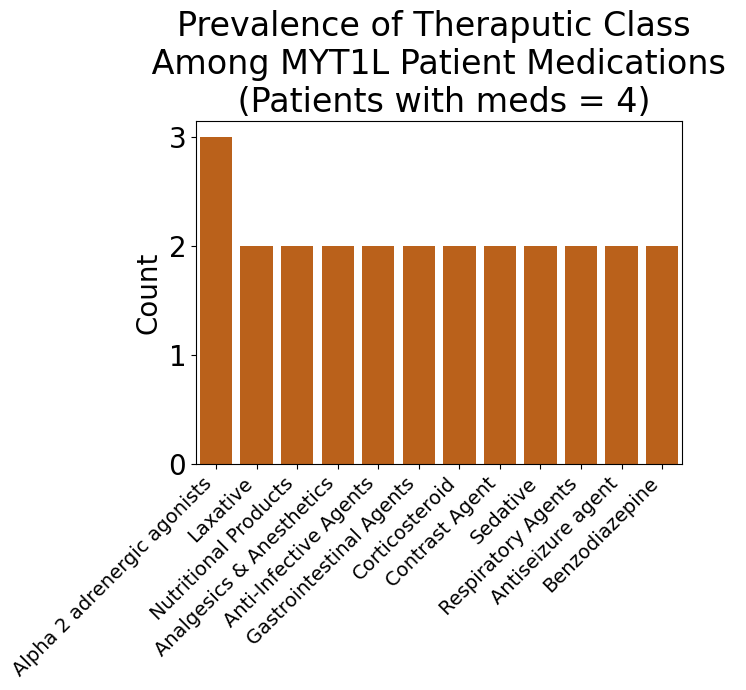

In [10]:
###### MEDICATIONS NAMEs
# map our medications to fixed names
med_mapping = pd.read_csv(med_names_mapped_loc)
plotting_df = gene_meds.merge(med_mapping[['medname','Corrected Name','Corrected Theraputic Class']], on = 'medname', how = 'left')

# reduce to one per patient
plotting_df = plotting_df.drop_duplicates(subset = ['participantid','Corrected Theraputic Class'])
num_patients = len(np.unique(plotting_df['participantid']))
plotting_df = plotting_df.groupby(['Corrected Theraputic Class'])['participantid'].count().reset_index().rename(columns = {'participantid':'count'}).sort_values(by='count', ascending = False)
### Keep only meds with more than 1 meds
plotting_df = plotting_df[plotting_df['count'] > 1]
plotting_df['Prevalence'] =  plotting_df['count']/num_patients

# # Create Figure
fig = plt.figure(figsize =(7, 7))
ax = sns.barplot(x = 'Corrected Theraputic Class', y = 'count', data = plotting_df, palette = ["#D55E00"])
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.xticks(rotation = 45, ha='right', fontsize = 17)
plt.yticks(fontsize = 20)
plt.title('Prevalence of Theraputic Class \n Among MYT1L Patient Medications \n (Patients with meds = ' + str(num_patients) + ')', fontsize = 24)
plt.xticks(ha = 'right', rotation = 45, fontsize = 14)
plt.xlabel('', fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.tight_layout()
plt.savefig("MYT1L_paper_figures/med_theraputic_class.svg",  format="svg", bbox_inches="tight")
plt.show()
plt.close()

# Supplementary More Specific Table

### Load Phecode Data

In [ ]:
# Load in Data
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
Phe_map = pd.read_csv(phecode_map_file, encoding = "latin-1").rename(columns = {'icd10cm':'icd10_code'})

# Load EHR encounters into single dataframe
encounter_dict = extract_filetype_csvs(deidentified_cielo_folder, "Encounters")
encounter_df = concat_single_csv_any(encounter_dict)
# Load EHR diagnoses into single dataframe
diagnoses_dict = extract_filetype_csvs(deidentified_cielo_folder, "Diagnoses")
diagnosis_df = concat_single_csv_diagnoses(diagnoses_dict)

from matplotlib.ticker import PercentFormatter
number_diagnoses_required_gene = 2
diagnosis_data = diagnosis_df.rename(columns = {"ICD10_CODE":"icd10_code", "PARTICIPANTID":"participantid"})

# Reduced to only note set 
if selected_gene != "All":
    gene_df['participantid'] = gene_df['EntityID']#.astype(int)
    diagnosis_data = diagnosis_data.merge(gene_df, on = "participantid")
    gene_diagnoses = copy.deepcopy(diagnosis_data[diagnosis_data['Brain Gene'] == selected_gene])
    other_diagnoses = copy.deepcopy(diagnosis_data[diagnosis_data['Brain Gene'] != selected_gene])

# Calculate the number of phecodes for our brain gene
number_gene_individuals  = len(np.unique(gene_diagnoses['participantid']))
print(f"Number of Individuals with Gene and Diagnoses: {str(number_gene_individuals)}")
gene_phecodes = gene_diagnoses.merge(Phe_map, on='icd10_code', how='left')
gene_phecodes = gene_phecodes.drop_duplicates(subset = ['participantid', "phecode_str"]).reset_index(drop=True)

# Code to determine if Each Individual has different phecodes 
phecodes_to_check = ['Lack of normal physiological development, unspecified', 'Symptoms of the muscles', 'Autism', 'Convulsions','Speech and language disorder','Attention deficit hyperactivity disorder']

# Create df we will save data in
phecode_supplement_df = pd.DataFrame({ "participantid": np.unique(gene_phecodes['participantid'])})
# Iterate though our phecodes
for phecode in phecodes_to_check:
    tmp_df = gene_phecodes[gene_phecodes['phecode_str'] == phecode]
    tmp_df.loc[:,phecode] = 'Yes'
    phecode_supplement_df = phecode_supplement_df.merge(tmp_df[["participantid",phecode]], on = 'participantid', how = 'left')
phecode_supplement_df.fillna('No', inplace = True)

Number of Individuals with Gene and Diagnoses: 9


### DP-4 and Shipley Results

In [ ]:
######################## DP-4

# load essential data
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

# Remove data from patients who do not have MYT1L from the data
patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report)

# Remove from data if individuals took a valid shipley 
shipley_invalid = np.unique(all_scores.loc[all_scores["Please indicate here if the Shipley assessment is considered invalid"].notnull(),'Study ID'])
all_scores_ship = all_scores[[True if x not in shipley_invalid else False for x in all_scores['Study ID']]]
also_took_shipley = np.unique(all_scores_ship.loc[all_scores['Shipley Standard Score'].notnull(),'Study ID'])
all_scores = all_scores[[True if x not in also_took_shipley else False for x in all_scores['Study ID']]].rename(columns = {"Study ID":"EntityID"})

# Merge on Gene and other things
# Condense to Correct Gene 
gene_df['EntityID'] = gene_df['EntityID'].astype(int)
all_scores = all_scores.merge(gene_df, on = "EntityID")
for i in range(len(all_scores)):
    if all_scores.loc[i,"Brain Gene"] != selected_gene:
        all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
gene_scores = all_scores[all_scores['Brain Gene'] == selected_gene]
gene_scores = gene_scores[gene_scores['DP4 Cognitive Standard Score'].notnull()]
dp4_supplement_df = gene_scores[['EntityID','DP4 Cognitive Standard Score']]


########################## SHIPLEY

# load essential data
gene_df = get_gene_data_RNAP(redcap_alldata_file)
# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report).rename(columns = {"Study ID":"EntityID"})

# # Merge on Gene and other things
gene_df['EntityID'] = gene_df['EntityID'].astype(int)
all_scores = all_scores.merge(gene_df, on = "EntityID")
for i in range(len(all_scores)):
    if all_scores.loc[i,"Brain Gene"] != selected_gene:
        all_scores.loc[i,"Brain Gene"] = "Other Brain Gene"
gene_scores = all_scores[all_scores['Brain Gene'] == selected_gene]
gene_scores = gene_scores[gene_scores['Shipley Standard Score'].notnull()]
shipley_supplement_df = gene_scores[['EntityID','Shipley Standard Score']]

### Vineland

In [ ]:
# Load in the essential data
colors = ['gray', 'darkblue']
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')
all_scores = pd.read_csv(redcap_feedback_report)

# Data Formatting and Creation!
all_scores = all_scores.rename(columns = {"Study ID": "EntityID"})
columns_to_investigate = ["Vineland Standard Score - Communication (COM)", 
                         "Vineland Standard Score - Daily Living Skills (DLS)",
                         "Vineland Standard Score - Socialization (SOC)",
                         "Vineland Standard Score - Motor Skills (MOT)",
                         "Vineland Standard Score - Adaptive Behavior Composite (ABC)"]
all_scores['EntityID'] = all_scores['EntityID'].astype(str)

myt1l_table = pd.read_csv(myt1l_table_loc).rename(columns = {"ID":"EntityID"})
myt1l_table['EntityID'] = myt1l_table['EntityID'].astype(str)
all_scores = all_scores[all_scores['EntityID'].isin(list(np.unique(myt1l_table['EntityID'].astype(str))))]
all_scores = all_scores[all_scores["Vineland Standard Score - Communication (COM)"].notnull()]
vineland_supplement_df = all_scores[['EntityID'] + columns_to_investigate]

### ASEBA Scores

In [ ]:
# Load in the essential data
colors = ['gray', 'darkblue']
gene_df = get_gene_data_RNAP(redcap_alldata_file)

# Perform Manually Defined AMCG Classification Modifications
### CODE REMOVED DUE TO PROTECTED HEALTH INFORMATION ###

patients_with_myt1l = gene_df.loc[gene_df["Brain Gene"] == "MYT1L", "EntityID"].unique()
gene_df = gene_df[
    (gene_df["EntityID"].isin(patients_with_myt1l) & (gene_df ["Brain Gene"] == "MYT1L"))
    | (~gene_df["EntityID"].isin(patients_with_myt1l))
]
gene_df = gene_df[gene_df['Econsent'] == "Complete"]
gene_df = gene_df.drop_duplicates(subset = 'EntityID')

# Add the all scores
all_scores = pd.read_csv(redcap_feedback_report)
all_scores = all_scores.rename(columns = {'ASEBA Attention_Deficit__Hyperactivity_Problems_TScore':"ASEBA ADHD_Problems_TScore", "Study ID":"EntityID"})
ASEBA_column_list = ['ASEBA Depressive_Problems_TScore',
                    'ASEBA Anxiety_Problems_TScore',
                    'ASEBA Autism_Spectrum_Problems_TScore',
                    'ASEBA Somatic_Problems_TScore',
                    "ASEBA ADHD_Problems_TScore", 
                    'ASEBA Oppositional_Defiant_Problems_TScore',
                    'ASEBA Conduct_Problems_TScore',
                    'ASEBA Avoidant_Personality_Problems_TScore',
                    'ASEBA Antisocial_Personality_TScore',
                    ]
all_scores['EntityID'] = all_scores['EntityID'].astype(str)

myt1l_table = pd.read_csv(myt1l_table_loc).rename(columns = {"ID":"EntityID"})
myt1l_table['EntityID'] = myt1l_table['EntityID'].astype(str)
all_scores = all_scores[all_scores['EntityID'].isin(list(np.unique(myt1l_table['EntityID'].astype(str))))]
aseba_supplement_df = all_scores[['EntityID'] + ASEBA_column_list]
aseba_supplement_df = aseba_supplement_df[~(aseba_supplement_df.isnull().sum(axis=1) == (len(aseba_supplement_df.columns) - 1))] 


### Combine and Pivot to Make Figure

In [15]:
# Perform Some formatting 
phecode_supplement_df.rename(columns = {"participantid":"EntityID"}, inplace = True)
phecode_supplement_df['EntityID'] = phecode_supplement_df['EntityID'].astype(str)
dp4_supplement_df['EntityID'] = dp4_supplement_df['EntityID'].astype(str)
shipley_supplement_df['EntityID'] = shipley_supplement_df['EntityID'].astype(str)
aseba_supplement_df['EntityID'] = aseba_supplement_df['EntityID'].astype(str)

# Get Our Table
supplement_df = myt1l_table[['EntityID']].merge(vineland_supplement_df, on = 'EntityID', how = 'left').merge(dp4_supplement_df, on = 'EntityID', how = 'left').merge(shipley_supplement_df, on = 'EntityID', how = 'left').merge(aseba_supplement_df, on = 'EntityID', how = 'left').merge(phecode_supplement_df, on = 'EntityID', how = 'left')
supplement_df['EntityID'] = list(range(1, len(supplement_df)+1))
supplement_df.to_csv("MYT1L_paper_figures/supplement_table.csv")